## Create Dataset

In [1]:
from lib.data_loader import PointCloudDataset
from torch.utils.data import DataLoader
import torch

In [2]:
point_cloud_dataset = PointCloudDataset(8500) #8480
dataloader = DataLoader(point_cloud_dataset, batch_size=25, shuffle=True)

In [4]:
import torch
from torch.autograd import Variable
from lib.auto_encoder import *
from lib.chamfer import ChamferLoss
from lib.callbacks import EarlyStopping

model = AutoEncoder()

criterion = ChamferLoss()

early_stopping = EarlyStopping(patience=50)

num_epochs = 1000
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if torch.cuda.is_available():
    model = model.cuda()

loss_list = []
for epoch in range(num_epochs):
    
    if epoch == 0:
        early_stopping.on_train_begin()

    running_loss = 0.0
    
    for data in dataloader:

        data = rotate_point_cloud(data.float())
                
        if torch.cuda.is_available():
            data = data.cuda()
            
        train_output = model(data)
        
        loss = criterion(train_output, data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data.detach() 
    
    loss_list.append(running_loss / data.shape[0])
    
    if early_stopping.on_epoch_end(epoch + 1, running_loss):
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss_list[-1]))
        print('Terminated Training for Early Stopping at Epoch %04i' % (epoch + 1))
        break
        
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss_list[-1]))

epoch [1/1000], loss:2127.2227
epoch [20/1000], loss:679.7343
epoch [40/1000], loss:598.5406
epoch [60/1000], loss:555.5869
epoch [80/1000], loss:529.6511
epoch [100/1000], loss:516.2346
epoch [120/1000], loss:507.9655
epoch [140/1000], loss:501.8989
epoch [160/1000], loss:493.1872
epoch [180/1000], loss:487.9612
epoch [200/1000], loss:490.5491
epoch [220/1000], loss:478.9925
epoch [240/1000], loss:472.0437
epoch [260/1000], loss:470.2649
epoch [280/1000], loss:469.0894
epoch [300/1000], loss:465.6242
epoch [320/1000], loss:463.0811
epoch [340/1000], loss:461.9401
epoch [360/1000], loss:460.9440
epoch [380/1000], loss:457.9065
epoch [400/1000], loss:456.1391
epoch [420/1000], loss:455.8429
epoch [440/1000], loss:452.0466
epoch [460/1000], loss:451.3905
epoch [480/1000], loss:449.7502
epoch [500/1000], loss:449.3309
epoch [520/1000], loss:447.5200
epoch [540/1000], loss:445.9124
epoch [560/1000], loss:445.6076
epoch [580/1000], loss:442.0266
epoch [600/1000], loss:442.5632
epoch [620/10

In [3]:
def rotate_point_cloud(batch_data):

    for k in range(batch_data.shape[0]):
        
        # 90, 180, 270 degree
        rotation_angle = int(np.random.uniform() * 4) * np.pi * 0.5

        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        
        rotation_matrix = torch.Tensor([[cosval, -sinval, 0],
                                    [sinval, cosval, 0],
                                    [0, 0, 1]])
        
        shape_pc = batch_data[k, ...].transpose(1, 0)
                
        batch_data[k, ...] = torch.matmul(shape_pc.reshape((-1, 3)), rotation_matrix).transpose(1, 0)
        
    return batch_data

## Training

#### save

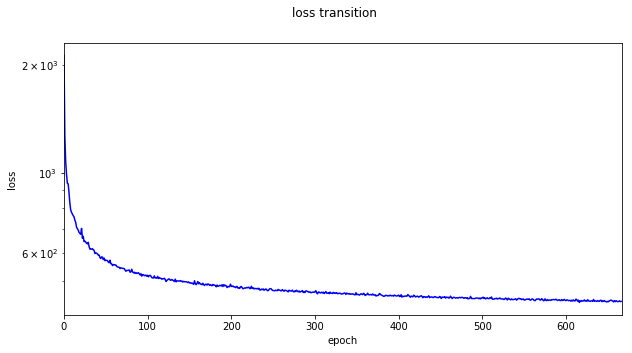

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))        
fig.suptitle('loss transition')
plt.semilogy(loss_list, label="loss", color='b')
plt.xlim([0, epoch + 1])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./models/%.4f.png' % loss_list[-1])
plt.show()

torch.save(model.encoder.state_dict(), './models/encoder_%.4f.pt' % loss_list[-1])
torch.save(model.decoder.state_dict(), './models/decoder_%.4f.pt' % loss_list[-1])

### get input values for validation

In [6]:
train_input  = next(iter(dataloader)).float()
train_input = rotate_point_cloud(train_input.float())

if torch.cuda.is_available():
    train_output = model(train_input.cuda())
    train_output = train_output.cpu()
else:
    train_output = model(train_input)

In [7]:
v_encoder = Encoder()
v_decoder = Decoder()

surfix = loss_list[-1]
v_encoder.load_state_dict(torch.load('./models/encoder_%.4f.pt' % surfix))
v_decoder.load_state_dict(torch.load('./models/decoder_%.4f.pt' % surfix))

## Generator

In [8]:
class Generator(AutoEncoder):
    
    def __init__(self, encoder, decoder):
        super(Generator, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.training = False

    def forward(self, x):

        x = self.encoder(x)        
        x = self.decoder(x)
        return x

In [9]:
generator = Generator(v_encoder, v_decoder)
generator_output = generator(train_input)

## Validation

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

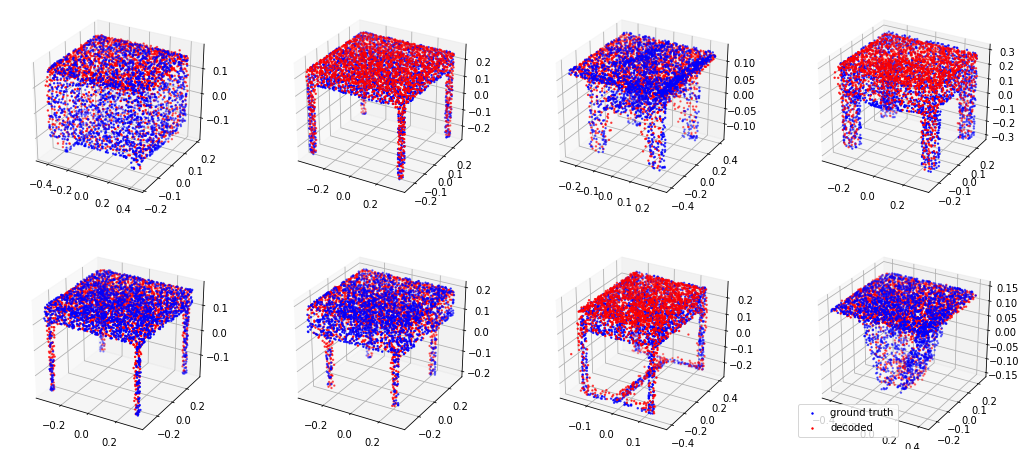

In [11]:
fig = plt.figure(figsize=(18, 8))

for i in range(8):
    
    row, columns, num = 2, 4, i + 1
    ax = fig.add_subplot(row, columns, num, projection='3d')

    data = train_input[i].detach().numpy()
    ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='b', label='ground truth')

    data = train_output[i].detach().numpy()
    ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='r', label='decoded')

#     data = generator_output[i].detach().numpy()
#     ax.scatter(data[0], data[1], data[2], zdir='z', s=4, c='g', label='decoded & modified')

ax.legend()
plt.show()

In [12]:
for i in range(8):
    d1 = train_input[i].detach().numpy()
    d2 = train_output[i].detach().numpy()
    print(np.sum(abs(d1 - d2)))

1261.6736
1229.5897
1057.848
1289.5481
1174.7368
1170.1948
1225.8253
973.99445


In [ ]:
# for i in range(8):
#     d1 = train_input[i]
#     d2 = train_output[i]
#     print(criterion(d1.reshape(1, 3, 2048), d2.reshape(1, 3, 2048)).data)

## Write to File

In [ ]:
def write(points, file_name, directory='./output/'):
    
    if points.shape[0] < points.shape[1] and points.shape[0] == 3:
        points = points.T
    
    with open(directory + file_name, 'w') as f:
        
        f.write(str(points.shape[0]) + '\n')

        for pt in points:
            f.write('%.8f %.8f %.8f\n' % tuple(pt))
    
write(next(iter(dataloader))[2].detach().numpy(), 'point_cloud.txt', '../pointcloud2mesh/mount/')

## TODOs

* Manimulate latent vector or try something else to generate more nice tables
* Reduce the number of point clouds or connect each points reasonably

## Misc

In [ ]:
input = torch.randn(10, 2048, 3)
print(input.shape)
m = nn.Conv1d(2048, 256, 1)
output = m(input)
print(output.shape)
m = nn.Conv1d(256, 128, 1)
output = m(output)
m = nn.Conv1d(128, 64, 1)
output = m(output)
print(output.shape)
m = nn.Conv1d(64, 32, 1)
output = m(output)
print(output.shape)
m = nn.MaxPool1d(3)
output = m(output)
print(output.shape)

In [ ]:
input = torch.randn(10, 3, 2048)
print(input.shape)
m = nn.Conv1d(3, 64, 1)
output = m(input)
print(output.shape)
m = nn.Conv1d(64, 128, 1)
output = m(output)
m = nn.Conv1d(128, 256, 1)
output = m(output)
print(output.shape)
m = nn.Conv1d(256, 512, 1)
output = m(output)
print(output.shape)
m = nn.MaxPool1d(2048) # output = torch.max(output, 2, keepdim=True)[0]
output = m(output)
print(output.shape)

In [ ]:
class TmpLoss(nn.Module):

    # https://github.com/345ishaan/DenseLidarNet/blob/master/code/chamfer_loss.py
    def __init__(self):
        super(TmpLoss, self).__init__()
        self.use_cuda = torch.cuda.is_available()        

    def forward(self,preds,gts):
        P = self.batch_pairwise_dist(gts, preds)
        mins, _ = torch.min(P, 1)
        loss_1 = torch.sum(mins)
        mins, _ = torch.min(P, 2)
        loss_2 = torch.sum(mins)
        return loss_1 + loss_2

    def batch_pairwise_dist(self,x,y):
        x = x.transpose(2, 1)
        y = y.transpose(2, 1)
        _, num_points_x, _ = x.size()
        _, num_points_y, _ = y.size()
        xx = torch.bmm(x, x.transpose(2,1))
        yy = torch.bmm(y, y.transpose(2,1))
        zz = torch.bmm(x, y.transpose(2,1))
        if self.use_cuda:
            dtype = torch.cuda.LongTensor
        else:
            dtype = torch.LongTensor
        diag_ind_x = torch.arange(0, num_points_x).type(dtype)
        diag_ind_y = torch.arange(0, num_points_y).type(dtype)
        rx = xx[:, diag_ind_x, diag_ind_x].unsqueeze(1).expand_as(zz.transpose(2,1))
        ry = yy[:, diag_ind_y, diag_ind_y].unsqueeze(1).expand_as(zz)
        P = (rx.transpose(2,1) + ry - 2*zz)
        return P

In [ ]:
input = Variable(torch.ones(2, 3, 12))
output = Variable(torch.zeros(2, 3, 12))
ls = TmpLoss()
ls.forward(input, output)

In [ ]:
xx = torch.bmm(input, input.transpose(2,1))
xx.shape

In [ ]:
input.transpose(2,1)

In [ ]:
! docker exec cgal /DeepTable/pointcloud2mesh/build/pointcloud2mesh.out ./mount/point_cloud.txt ./mount/output.off

In [ ]:
def load_file(file_name):
    vertices = []
    with open(file_name) as f:
        for i, line in enumerate(f):
            vals = line.split(' ')
            if i > 2 and len(vals) == 3:
                vertex = [float(vals[0]), float(vals[1]), float(vals[2])]
                vertices.append(np.array(vertex))

    return np.random.permutation(np.array(vertices))[:2048]

lines = load_file('../pointcloud2mesh/mount/output.off')
pts.shape
# trace = go.Mesh3d(x=x,y=y,z=z,color='#FFB6C1',opacity=0.50)
# py.iplot([trace])